## <span style="color:red">Motivation</span>

# The Story of Hollywood - Hollywood as a voice of the times and the cliques that lie within it's top
People have throughout history always look for ways to express themselves through art and since the invention of the Kinetograph, which was the first motion picture camera, by Thomas Edison and his British assistant William Dickson 1890 [1](https://www.pbs.org/wgbh/americanexperience/features/pickford-early-history-motion-pictures/#:~:text=In%201888%20in%20New%20York,a%20primitive%20motion%20picture%20camera.), motion pictures have become increasingly popular. In 2020 the box-office revenue in the US alone was USD $11.300.000$

Skriv noget mere

### Data
Almost everyone have a strong relationship to movies, the intrigue, enlighten, make you cry and make you laugh. We wanted to know more about the structure of the largest productions of them all, and that is why the project evolves around the [tmdb 5000](https://www.kaggle.com/tmdb/tmdb-movie-metadata) dataset. This dataset contains data on the plot, cast, crew, budget, and revenues of several thousand films, but have the advantage that the data is already filtered and cleaned. We choose this dataset as is provides a good foundation of our analysis, but other data sources will also in the report to verify and support the findings.


### Goal of the project
The overall idea of this project is to investigate interesting properties of Hollywood acting environment and how it has developed over time? As the dataset contains a lot of information, these properties have split into two major areas of focus. 
* Movies as a Voice of the times and the Evolution of Hollywood itself
* Hollywood as a closed community structue, with few Actors working alot together. Furthermore, that these communities also exsist outside the set of the movies

There are of course many more interesting elements to look at, kaggle suggests looking at "... the success of a movie before it is released?", or "Are there certain companies (Pixar?) that have found a consistent formula?", but our goal is that after having read this notebook, one would have gotten an in depth understanding of **hollywood as a voice of the times** and **the closed community structure of it**


NOTE: also that the reader experiance some beautifull plots 


## <span style="color:red">Basic stats</span>
<span style="color:red">Data processing and cleaning</span>

<span style="color:red">Introduction to datasets</span>

## Basic stats of the Data and network

This section will present some basic information about the dataset and initial preperation to allow for the reader to get a good idea abouyt the data the project is working with

In [181]:
#Imports
from IPython.display import Image, clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import re
import nltk
import json
import bar_chart_race as bcr
import random
from fa2 import ForceAtlas2
import json
from collections import Counter, defaultdict
import urllib
from datetime import datetime
from ipywidgets import *
import ipywidgets as widgets
import time
import math
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import seaborn as sns
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

#import gif


#Init stopwords
stop_words = set(stopwords.words('english'))

### IMDB 5000
<span style="color:red">WHAT IS THE DATA ETC: WRITE MORE</span>


In [2]:
# Datasets
RELATIVE_FILE_PATH=''
movies = pd.read_csv(RELATIVE_FILE_PATH+'tmdb_5000_movies.csv')
credits = pd.read_csv(RELATIVE_FILE_PATH + 'tmdb_5000_credits.csv')

In [3]:
# Creating DF
df = movies.merge(right = credits, left_on = 'id', right_on = 'movie_id')
df['release_date'] = pd.to_datetime(df['release_date'])


#Convert JSON to dict and extract the names of each actor in each movie
actors_per_movie = df['cast'].apply(lambda x: ','.join([y['name'] for y in json.loads(x)])).str.split(',', expand = True).fillna('')
actors_per_movie = df[['original_title', 'id']].merge(right = actors_per_movie, left_index = True, right_index = True)

#Unpivot
actors_per_movie = actors_per_movie.melt(id_vars=['original_title', 'id'])

#Remove empty rows
actors_per_movie = actors_per_movie[actors_per_movie['value'] != '']

#Number of movies per actor
pt = actors_per_movie.pivot_table(index = 'value', values='id', aggfunc = len).reset_index().sort_values(by='id', ascending = False).reset_index()

In [4]:
pt.head()

index              value  id
0  45586  Samuel L. Jackson  67
1      2                Jr.  60
2  43599     Robert De Niro  57
3   6819       Bruce Willis  51
4  34677         Matt Damon  48

In [5]:
print(f"In the original {len(df)} movies, there are {len(pt)} actors. Of these actors {len(pt[pt['id']<5])} have starred in less than 5 movies")

In the original 4803 movies, there are 54199 actors. Of these actors 50394 have starred in less than 5 movies


#### Decreasing the size of the data

We now have the full dataset, but as we can see above there are quite Actors in this network that contribute very little information to the questions we want to answer. Modelling the network with actors as nodes and movies as the links between them we will have alot of low degree nodes potentially disturbing the picture.
Many of these low degree actors are most likely extras, but since there are only 4803 movies in the data and as of 2012 the United States has produced roughly 44.000 [movies](https://babelniche.com/2013/06/29/where-are-movies-made/) according to IMDB. 

Due to this, and also to reduce the complexity we have decided to only look at the top 500 most productive actors and actresses

In [6]:
#Select top N actors by number of movies
pt = pt.nlargest(500, 'id')
#Top N actors as Nodes
nodes = pt['value'].tolist()

#### The Network itself
As mentioned the network will consist of actors as nodes and movies as edges. Of course actors can participate in multiple movies together, and this is also part of our investigation. To handle this we will model the network as a weighted undirected graph where the weight is the number of movies the actors starred together in.

The network is also going to contain some other basic stats on nodes and edges:

**Edges**
* Weight
* Movie id list ( NOT IMPLEMENTED)

**Nodes**
* Name of actor/actress
* Movie id list
* Genre dictionary

The reason we only store the id's and not the full data is to reduce redundance and while not decreasing speed

In [7]:
# Creating the network

# Extracting genre
movie_genre={}
for x in movies.iterrows():
    movie_genre[x[1]['original_title']]=[y['name'] for y in json.loads(x[1]['genres'])]

    
#Create edges between actors that have been in the same movie
edges = []
actor_genre = {}
actor_movies_count = {}
actor_movies_list = {}
edge_movie_lookup = {}
for node in nodes:
    actor_movies = actors_per_movie[actors_per_movie['value'] == node]['original_title'].tolist()
    edges += [(node, x) for x in\
              actors_per_movie[(actors_per_movie['original_title'].isin(actor_movies)) \
                & (actors_per_movie['value'].isin(nodes))]['value'] if node != x]

    # Actor
    cnt=len(actor_movies)
    actor_movies_count[node] = cnt
    actor_movies_list[node] = actor_movies
    actor_genre[node]=[movie_genre[y] for y in actor_movies]


In [8]:
# Init graph
G = nx.Graph()

# Add nodes and edges
G.add_nodes_from(nodes)
G.add_edges_from(edges)

In [9]:
# Set attributes

ct=Counter(edges)
# Add weights
for key, value in ct.items():
    G.edges[key]['weight'] = value
    
# Generate list of movies for edges
for key, value in edge_movie_lookup.items():
    G.edges[key]['movies']=value

# Add most frequent genre
for actor in G.nodes:
    G.nodes[actor]['genre']=Counter([x for y in actor_genre[actor] for x in y])
    G.nodes[actor]['top_genre']=G.nodes[actor]['genre'].most_common(1)[0][0]
    G.nodes[actor]['top_genre']
    G.nodes[actor]['movies_count']=actor_movies_count[actor]
    G.nodes[actor]['movies']=actor_movies_list[actor]

In [10]:
# Taking a look at a node in the graph
print(actor)
for x in G.nodes[actor]:
    print (f"{x}:",G.nodes[actor][x])

Elisabeth Shue
genre: Counter({'Drama': 8, 'Comedy': 7, 'Thriller': 5, 'Romance': 4, 'Science Fiction': 4, 'Horror': 3, 'Adventure': 3, 'Family': 3, 'Action': 2, 'Mystery': 2, 'Crime': 1, 'Music': 1})
top_genre: Drama
movies_count: 17
movies: ['Piranha 3D', 'Molly', 'Hollow Man', 'The Saint', 'Don McKay', 'Leaving Las Vegas', 'Chasing Mavericks', 'House at the End of the Street', 'Back to the Future Part II', 'Dreamer: Inspired By a True Story', 'Hide and Seek', 'Back to the Future Part III', 'The Karate Kid', 'Deconstructing Harry', 'Gracie', 'Hamlet 2', 'Hope Springs']


### WIKIPEDIA YEAR LOOKUP

The second part of the dataset is a lookup of an the year/decades wikipedia page to see if the findings from our analysis corresponds to the sentiment found on the pages. The purpose and hypotesis of this is that we will find a direct correlation between the sentiment of movies and the sorrunding decands data.

One assumption here is that will let the production of hollywood reflect the general state of the world. The reason for this is that there is no pattern wikipedia pattern for year/decade lookup only for the us. Scraping multiple sites will take too much time and loose focus of the important stuff. A reason why this assumption might be allright is due to the fact that the earlies movies in the dataset start around 1970's, which means that society is quite globalised already

**Cleaning and preprocessing**
The data is fetched through the api and is parsed using regex to a raw but filtered state

The filtering applied is:
* Removing links an references to other pages identified by being within <> or {}
* Removing links identified by starting with url=
* Removing non alpha numeric charaters
* Removing links identified by starting with http

This leaves us some partly filtered data still containing stopwords etc. ready for analysis

In [11]:
#The content of the characters' wiki-pages is extracted using the wikipedia API
baseurl = 'https://en.wikipedia.org/w/api.php?'
action = 'action=query'
title = 'titles='
content = 'prop=revisions&rvprop=content'
dataformat = 'format=json'

def look_up_decade(year: int)-> str:
    decade_start=int(year/10)*10
    query = '%s%s&%s&%s&%s' % (baseurl,action,f'titles={decade_start}s',content,dataformat)
    res = json.loads(urllib.request.urlopen(query).read().decode('utf-8'))
    pages = res.get('query').get('pages')
    if not pages:
        raise Exception('No pages found')
    data = []
    for page in pages.keys():
        try:
            data.append(res['query']['pages'][page]['revisions'][0]['*'])
        except:
            print(f"Failed on pages{page}")
    return data

def process_data(d:list, limit=3)->list:
    data_string = ''
    temp_str = ''
    
    i=0
    for x in d:
        if i>=limit:
            break
        # Remove special chars and data in links
        temp_str=re.sub("[\{\<.*?[\}\>]", "", x)
        # Remove links
        temp_str=re.sub('url=.\S*','',temp_str)
        # Weird chars
        temp_str=re.sub('[^a-zA-Z0-9 \n\.]', '', temp_str)
        # Remaning links
        temp_str=re.sub('http.\S*','',re.sub('[^a-zA-Z0-9 \n\.]', '', temp_str))
        # Remaning links
        temp_str=re.sub('redirect.\S*','',temp_str)
        data_string += temp_str
        i+=1
    return data_string    

## <span style="color:red">Analysis part one Hollywood</span>



## Analysis of Hollywood Evulution

How does the hollywood network look like and how has it changed over time=

In this section we will dive into the network and explore different attributes of the network such to gain an insight into the elite of hollywood. This will be structured into the 6 subsections listed below.

* Investigation of the network - Get at reference point to some of the well known and documented networks
    * [x] Links
    * [x] In and out degree
    * [x] Visualisation of the entire network with relevant attributes - SHOULD BE IMPROVED
    * [ ] Comparison with Random Network
    * [ ] Changes in degree distribution over time
    
* Genre - How are the top of hollywood distributed across genres
    * [x] Genre distribution over time
    * [x] Genre popularity compared to average budget
    * [ ] Particular patterns of actors work in genres - Asbjørn

* Important words - What words stand out using TF-IDF schemas of the decades and across genres and decase
    * [ ] TF-IDF
    * [ ] Relation to dominant genres
    * [ ] Wordclouds
    * [ ] Most important words -> similarity with the decades wikipedia page

* Sentiment - How do people interpet the words of these segmentations?
    * [ ] How does it relate to the TF-IDF
    * [ ] Does it reflect the major events of the us/world?

* Actor communities - What actors constitute movie communities and how has this changes over time?
    * [ ] Are the communities high budget highly rated?

* Wrapup - Can we generalize the trends in hollywood?


### Network investigation
To gain deeper insight into our network we will start off by letting the data talk

In [13]:
# ANALYSIS
print(f"Number of nodes in network: {G.number_of_nodes()}")
print(f"Number of links (edges) in network: {G.number_of_edges()}")
print(f"Average number of links per node: {round(G.number_of_edges()/G.number_of_nodes(),2)}")
print(f"Average shortes path: {round(nx.algorithms.average_shortest_path_length(G),4)}")

Number of nodes in network: 500
Number of links (edges) in network: 18218
Average number of links per node: 36.44
Average shortes path: 1.8567


In [14]:
in_degree = sorted([(d,n) for n, d in G.degree()], reverse=True)
print('Top 5 most connected characters (movies, Actor)')
print(*in_degree[0:5], sep='\n')

Top 5 most connected characters (movies, Actor)
(176, 'Samuel L. Jackson')
(148, 'Owen Wilson')
(142, 'John C. Reilly')
(141, 'Bruce Willis')
(140, 'Steve Buscemi')


From the above we see that the network is very highly connected with ever node on average connecting to a 36.44 characters and an average shortest path only being 1.85. Relating this to the small world phenomenon known as six degrees of separation, which refeers to "two individuals, anywhere in the world, can be connected through a chain of six or fewer acquaintances"[\[1\]](http://networksciencebook.com/chapter/3#small-worlds), this network already by itself a community relating it to the larger population

From the data it looks like the actors are contributing to a very similiar amount of movies, which could lead one to believe that the network amongst the top 500 does not follow a **power law distribution** 

Lets take a look at this along, with the productivity over time for the actors

In [15]:
# Degree
degree = sorted(G.degree, key=lambda x: x[1], reverse=True)
# Splitting the sequence
degree_sequence = sorted([d for n, d in degree], reverse=True)
# Creating the histogram bins and counts
hist, bin_edges = np.histogram(np.array(degree_sequence), bins=np.arange(degree[-1][1], degree[0][1]+2))

# For the barplot
degreeCount = Counter(degree_sequence) # Count the degrees
deg, cnt = zip(*degreeCount.items()) # deg: degree, cnt: the count of the degree


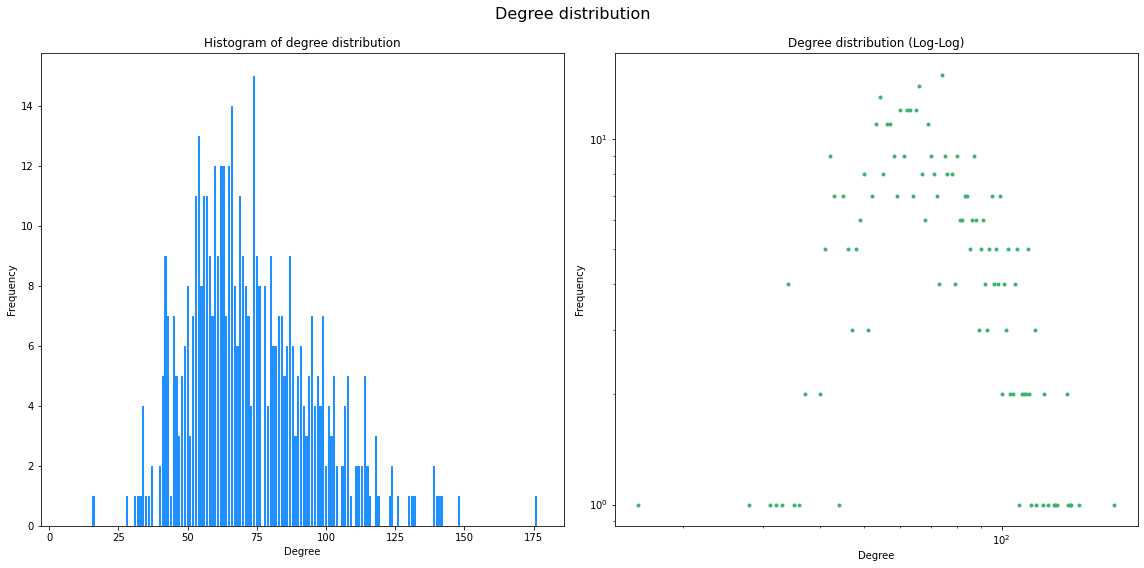

In [16]:
# Plot:
fig, axarr = plt.subplots(1, 2, figsize=(16,8))
fig.suptitle("Degree distribution", fontsize=16)

axarr[0].bar(deg,cnt,color='dodgerblue')
axarr[0].set_xlabel('Degree')
axarr[0].set_ylabel("Frequency")
axarr[0].set_xlim([-3,max(deg)+10])
axarr[0].set_title("Histogram of degree distribution")

axarr[1].loglog(bin_edges[:-1],hist,'.', color="mediumseagreen")
axarr[1].set_xlabel('Degree')
axarr[1].set_ylabel("Frequency")
axarr[1].set_title("Degree distribution (Log-Log)")

fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

In [17]:
# Reverse lookup for speed increase
reverse_movie_year_lookup={}
for row in df.iterrows():
    if pd.isna(row[1]['release_date']):
        continue
    reverse_movie_year_lookup[row[1]['original_title']] = row[1]['release_date']

#Extract data
relase_data = []
for node in G.nodes:
    actor_movies = sorted([reverse_movie_year_lookup[x].year for x in G.nodes[node]['movies']])
    first_release = min(actor_movies)
    actor_movies = [x-first_release for x in actor_movies]
    relase_data.append((node, actor_movies, [x for x in range(1,len(actor_movies)+1)]))
    
    

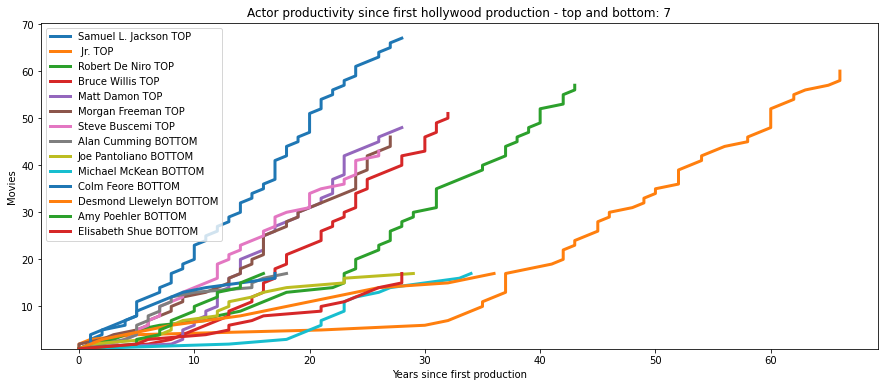

In [18]:
limit=7
l_relase_data=len(relase_data)
relase_data=sorted(relase_data, key=lambda x: len(x[1]), reverse=True)[0:limit]+sorted(relase_data, key=lambda x: len(x[1]), reverse=True)[l_relase_data-limit:l_relase_data]
fig, ax = plt.subplots(figsize=(15, 6))
for i in range(len(relase_data)):
    l_postfix=' TOP'
    if i>=limit:
        l_postfix=' BOTTOM'
    ax.plot(relase_data[i][1], relase_data[i][2], label=relase_data[i][0]+l_postfix,linewidth=3)
ax.set_ylim(1)
ax.set_ylabel('Movies')
ax.set_xlabel('Years since first production')
plt.title(f'Actor productivity since first hollywood production - top and bottom: {limit}')
plt.legend()
plt.show()

This seems to validate our assumption of the network to not follow a powerlaw distribution. The data semmes normal distributed around 65 with a slight right skewness, though not completely. The initial analysis of this plot would lead one to belive that there can be actually quite a large gap between the top and bottom actors. There might be, but the distribution plot removes the focus from the fact that some actors have been much longer in the business, and therefore have had more time to produce movies. For this the actor productivity provides alot more information about what the differences are between the actors productivity.

The plot of actor productivity seems to a story along the same lines, that even between **the top 500 Actors** there are quite a big diffenrence in productivity between the top and bottom. Samuel L. Jackson has produced around 20 movies pr. decade while Michael McKean produces around 6 in the first 20 years

**Overvejelse om dette skal fjernes**
Relating this to the movies industry we also know that some actors can produce very large amount in a short time without great imdb scores where as others work on slower productions with a higher focus on production values.

### Visual representation of the network

Lets take a look at the full network sizing the actors after productivity, coloring after most common genre, and letting opacity of edges reflect how much two actors have worked together

### <span style="color:red">ADD SIZING OF NODES</span>



In [19]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        edgeWeightInfluence=0.6,

                        # Performance
                        jitterTolerance=0.15,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.7,

                        # Tuning
                        scalingRatio=4.0,
                        strongGravityMode=True,
                        gravity=1.0,

                        # Log
                        verbose=True)

In [20]:
#@gif.frame
def weight_color_map(weight):
    get_tuple = lambda x: tuple(x for y in range(3))
    if weight<2:
        return get_tuple(1)
    elif weight <3:
        return get_tuple(0.7)
    elif weight <5:
        return get_tuple(0.6)
    else:
        return get_tuple(0.3)
    
    
def plot_graph(G, actor_label_movie_limit=40):
    color_map = {}
    for genre in list(set([G.nodes[x]['top_genre'] for x in list(G.nodes)])):
        color_map[genre] = []

    for node in G.nodes:
        color_map[G.nodes[node]['top_genre']] += [node]
    fig, ax = plt.subplots(figsize=(18,16))

    positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
    
    color = {'Action': 'Red', 'Adventure': 'Blue', 'Animation': 'Pink', 'Comedy': 'Green', 'Crime': 'Brown',\
          'Drama': 'Cyan', 'Family': 'Yellow', 'Thriller' : 'White', 'Romance': 'Orange', 'Science Fiction': 'Black'}
    
    
    # Missing node sizing
    for key in color_map.keys():
        nx.draw_networkx_nodes(G,pos=positions,nodelist=color_map[key],\
            node_size=300, node_color=color[key], label=key, ax=ax)
        #[G.degree(y) for y in color_map[key]]
    
    colormap_edges = [weight_color_map(G[u][v]['weight']) for u,v in edges]
    opacitymap_edges = [weight_color_map(G[u][v]['weight']) for u,v in edges]
    nx.draw_networkx_edges(G, positions, edge_color=colormap_edges, alpha=0.5, ax = ax)
    ax.legend(scatterpoints = 1)
    nx.draw_networkx_labels(G, positions,{y:'' if G.nodes[y]['movies_count']<actor_label_movie_limit else y for y in positions.keys()}, font_size=14, ax = ax)
    ax.axis('off')
    ax.set_title('Top 500 Actors \n Colored after most common genre, sized after total feature films')
    return ax

100%|██████████| 2000/2000 [00:07<00:00, 257.83it/s]


BarnesHut Approximation  took  1.45  seconds
Repulsion forces  took  4.66  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  1.23  seconds
AdjustSpeedAndApplyForces step  took  0.18  seconds


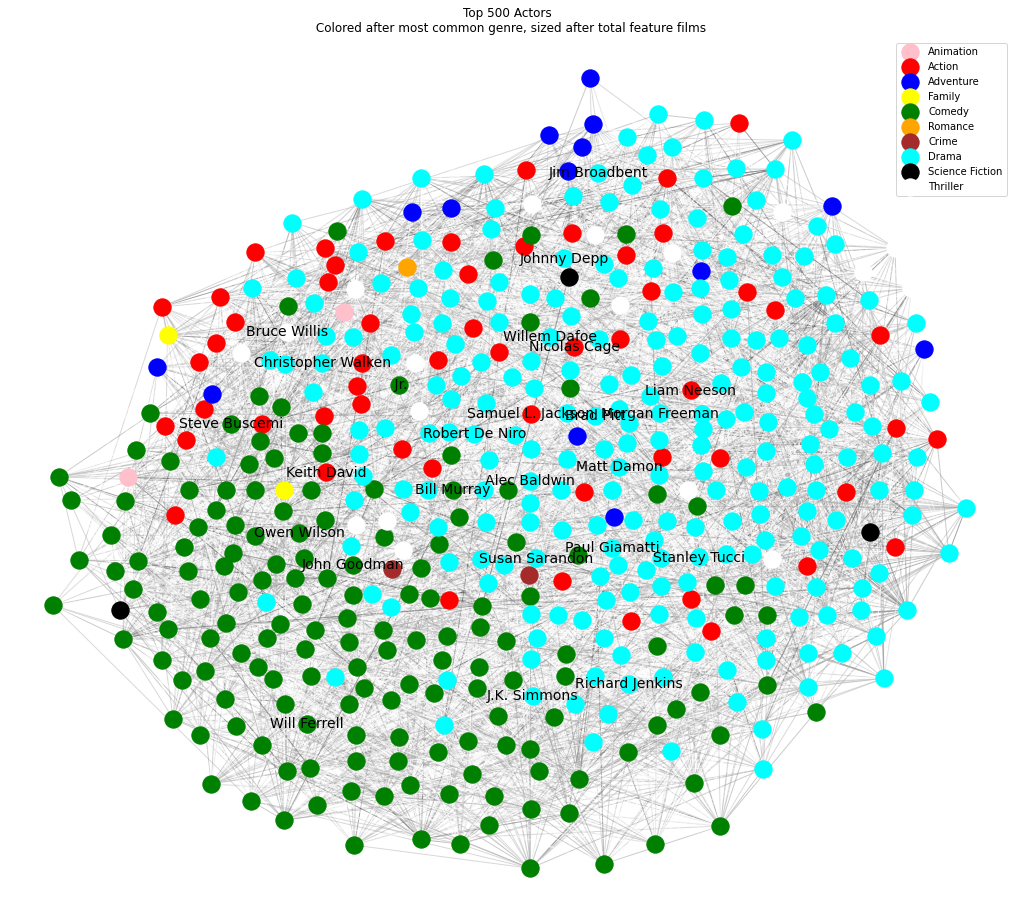

In [21]:
ax = plot_graph(G, actor_label_movie_limit=35)
plt.show()

From the above plot we see that there seem to be an overweight of actors acting within the genres of Comedy and Drama. As the connection degree so high it's a bit difficult to see what is going on, but we see that there definitly are some central noedes in the network.

**Sig lidt mere og forbedre graf**
* Tilføj nodesize
* Find en smart måde ikke at plotte edges der er under 2 etc.

## <span style="color:red">Remove before final version</span>

### Create GIF

In [22]:
gif.options.matplotlib["dpi"] = 800

NameError: name 'gif' is not defined

In [ ]:
rand_neighbors = []

for i in range(20):
    n1 = np.random.randint(low = 20, high = 40)
    n2 = np.random.randint(low = 5, high = 8)
    n = list(G.neighbors('Samuel L. Jackson'))[n1:n1+n2] + ['Samuel L. Jackson']
    rand_neighbors += [n]

In [ ]:
%%capture
frames = []
for n in rand_neighbors:
    frame = plot_graph(G.subgraph(n))
    frames.append(frame)

In [ ]:
gif.save(frames, 'network.gif', duration=40, unit="s", between="startend")

### End GIF

## Genre

Now that we have a basic understanding of the network we can start taking a look at how the movie distribution looks across genres. In the network plot we saw a larger overweight of drama and comedy actors, but this the based on their most common genre. Even if there is only a small differece in number of total genre features.

In [ ]:
# Has there been a large change in the most popular genre
df.sort_values('release_date', inplace=True)

genres=set([y for x in movie_genre.values() for y in x])
data = defaultdict(lambda: defaultdict(int))

for x in df.iterrows():
    for y in json.loads(x[1]['genres']):
        data[x[1]['release_date'].year][y['name']]+=1
# Set missing values
for k in data.keys():
    missing_k=genres.difference(set( x for x in data[k].keys()))
    for genre in missing_k:
        data[k][genre]=0

### <span style="color:red">FIX INTERACTIVE PLOT</span>


Below we can interact with horizontal bar plot showing genre activity across the different years.

In [ ]:
%matplotlib notebook

np.random.seed(19680801)
plt.rcdefaults()
y_pos = np.arange(len(genres))
# Get names a lazy way
genres_ = [x[0] for x in sorted(data[2000].items())]
colors = np.random.rand(len(genres),3)
ax.set_yticks(y_pos)
ax.set_yticklabels(genres_)
ax.set_xlabel('Performance')
ax.set_title('Genre distribution')


def update(year):
    performance = [x[1] for x in sorted(data[year].items())]
    plt.barh(y_pos, performance, align='center', color=colors)
    plt.xlabel('Performance')
    plt.title('Genre distribution')

interact(update, year = data.keys());

Invesitgating for different years we see that in the early period of dataset - before 1970 - there is not a lot of datapoints. Lets plot a small movie to see how it changes from beginning to of data

In [ ]:
# Multiple plots shown as a movie

%matplotlib inline
np.random.seed(19680801)
plt.rcdefaults()

cumm=True

# Example data
y_pos = np.arange(len(genres))
colors = np.random.rand(len(genres),3)
#lazy init
labels_=[x[0] for x in sorted(data[2000].items())]

cumm_data=np.zeros(len(labels_))
for year in data.keys():    
    performance = [x[1] for x in sorted(data[year].items())]
    cumm_data+=performance
    if cumm:
        performance=cumm_data
    plt.barh(y_pos, performance, align='center', color=colors)
    plt.xlabel('Performance')
    plt.yticks(y_pos,labels_)
    plt.title(f"Distribution of Genres Year: {year}")
    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)

From the above plot we see that drama seems to have been the main genre since the begining of the dataset. Something else that stands out is the rise of popularity of espacially comedy and thrillers in the 1990 and onwards. This might be due to the rise of sitcoms such as Friends and Seinfield, which might also have bought the genres into the theaters. To verify or reject this hypotesis, is obvius to the a look at development in genre budgets over time. This has been plotted below

In [27]:
# Generate budget data
data_budget = defaultdict(lambda: defaultdict(list))

for x in df.iterrows():
    for y in json.loads(x[1]['genres']):
        data_budget[x[1]['release_date'].year][y['name']].append(x[1]['budget'])
# Set missing values
for k in data_budget.keys():
    missing_k=genres.difference(set( x for x in data_budget[k].keys()))
    for genre in missing_k:
        data_budget[k][genre]=[0]
        

NameError: name 'genres' is not defined

In [ ]:
for year in data_budget.keys():    
    performance = [x[1] for x in sorted(data_budget[year].items())]
    break

In [ ]:
# Multiple plots shown as a movie

%matplotlib inline
np.random.seed(19680801)
plt.rcdefaults()

cumm=True

# Example data
y_pos = np.arange(len(genres))
colors = np.random.rand(len(genres),3)
#lazy init
labels_=[x[0] for x in sorted(data[2000].items())]

cumm_data=np.zeros(len(labels_))
for year in data.keys():    
    performance = [x[1] for x in sorted(data_budget[year].items())]
    performance = [np.mean(x) if x else 0 for x in performance]
    if cumm:
        # Update cumm mean
        for i in range(len(performance)):
            val = performance[i]
            if val:
                cumm_data[i]=(cumm_data[i]+val)/2
        performance=cumm_data
    plt.barh(y_pos, performance, align='center', color=colors)
    plt.xlabel('Budget')
    plt.xlim((0,2e8))
    plt.yticks(y_pos,labels_)
    if not cumm:
        plt.title(f"Distribution of Genres Budgets for year: {year}")
    else:
        plt.title(f"Distribution of Genres Budgets for year cumulative: {year}")
    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)

What we see above is as expected an increase in the average budget size from the 1990 and onwards to the aboce mentioned genres, but this actually happends across the line which makes it difficult to distinguish any of the patterns indicated in the genre count distrbution. 

#### Patterns of actors work within genres

Now that the general patterns of genre has been unraveled, we can take a look how it evolves on the a selected few actors to see if we can also spot a change in the actors genre distribution pr. year around the turn of the decade.

If we see a change around this point for the two genres to becomes more popular around it would indicate that the industry is transitioning into more focus on these genres. Alternatively, it could be due to a lot of new talent emerging into the market in primarly these genres.

## <span style="color:red">Insert Asbjørns plots on actor development</span>

### Important words of the decade
Now that we have a good idea of how the network has evolved and what genres are the dominant ones lets take the initial steps to look if we can regonize the mood of the times through the use of TF-IDF. Does these correspond with the genre distribution? How does it look when we relate the decade to what is happening in the world? And do the dominant elements from the genres correspond to what we expect?


#### TF-IDF calculation
The term TF-IDF is short for term frequency–inverse document frequency[\[2\]](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

TF-IDF is a statistical measure for the importance of a word in a document or corpus. The goal of using this statistical measure is to idetify themes or elements of importance within the identified communities. The expected result is for example some words related to violence and crime to be dominant within the villan community surrounding The Joker


#### Calculation of TF-IDF
The calculation of TF-IDF can be done in many ways. Examples of TF are

>Boolean "frequencies": tf(t,d) = 1 if t occurs in d and 0 otherwise;
term frequency adjusted for document length: tf(t,d) = ft,d ÷ (number of words in d)
logarithmically scaled frequency: tf(t,d) = log (1 + ft,d);
augmented frequency, to prevent a bias towards longer documents\[2\]

Because the document as fairly similiar for all the movies the bare count was choosen as the TF.

For the IDF the $log(1+\frac{N}{1+n_t})$ was choosen, as it is a common choice with the +1 in the denominator ensuring not division by zero and the other +1 ensuring >1 value for the log fuction.

#### Documents and Collections
As mentioned earlier the TF-IDF measure is a measure for a single document in a corpus. The problem has been modelled in the following way:
* The documents $ D $ are the joined overview for the given segmentation - decade in this case 
* The collection $ C $ is the joined documents for all the movies in the  **dataset/corpus** (kan dette siges?)

#### Stopwords
Stopwords contribute very little information and usually gets filtered out through the inverse document frequency, but since the collections is quite small in this case around 8, the IDF penalty for occuring in many documents is simply too small compared to the raw count of the stopwords. To limit problems with this is has been decided to remove the stopwords all together

We start off by creating helperfunctions to assist in the data loading process

In [24]:
def load_segmented_documents(dataf, start_year:int, segment_years:int)-> defaultdict:
    document_data = defaultdict(str)
    for x in dataf.iterrows():
        # Skip
        if pd.isna(x[1]['release_date']):
            continue
        # Skip
        if pd.isna(x[1]['overview']):
            continue
        # Skip
        if x[1]['release_date'].year<start_year:
            continue
        y = int(x[1]['release_date'].year/segment_years)*segment_years
        document_data[y]+=(x[1]['overview'])
        dataf.iloc[x[0]]['segment_year']=y
    return document_data

        
def calculate_tf_idf(document: list, collection: list):
    # Tr calculation
    # Naive count
    tf = Counter(document)
    # other variations
    #for k in tr: tr[k] = math.log10(tr[k]+1)
    #for k in tr: tr[k] /= len(document)
    
    # IDF
    N=len(collection)
    # Flattens data
    idf = defaultdict(int)
    for d in collection:
        words = set(d)
        for x in words:
            idf[x]+=1
    
    # Calculate IDF from n and n_t
    for k in idf: idf[k] = math.log(1+ N/(idf[k]+1))
    tfidf={k:tf[k]*idf[k] for k in tf}
    
    return tfidf

def tokenize(text:str, remove_stop_words=True)-> list:
    tokenized = [word.lower() for word in nltk.word_tokenize(text) if word.isalpha()]
    if remove_stop_words:
        stop_words = set(stopwords.words('english'))
        tokenized = [x for x in tokenized if x not in stop_words]
    return tokenized


In [25]:
# Extracting the data from 1970 with 10 year segments
docs=load_segmented_documents(df,1970,10)
collection=[tokenize(v) for v in docs.values()]

tfidf=dict()
for year_segment, text in docs.items():
    tfidf[year_segment]=calculate_tf_idf(tokenize(text), collection)

/Users/admin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/admin/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Lets take a look at the first decade in our list and see what we find and if it relates to what we would expect for that decade

In [26]:
y=[x for x in tfidf.keys()][0]
print(f"The first decade in our data is {y}\n")
top_x=10
print(f"The top {top_x} most important words found by idf are:")
for x in [x[0] for x in sorted(tfidf[1970].items(), key=lambda x: x[1], reverse=True)[0:top_x]]:
    print(x)
top_movies=7
print(f"\nThe top {top_movies} grossing movies this decade was:")
df['decade']=df['release_date'].apply(lambda x: int(x.year/10)*10 if not pd.isna(x) else x)
print(df[df['decade']==y].sort_values('budget',ascending=False)[['original_title','budget']][0:top_movies])
print(f"\nThe top {top_movies} rated movies this decade was:")
print(df[df['decade']==y].sort_values('vote_average',ascending=False)[['original_title','vote_average']][0:top_movies])

The first decade in our data is 2000

The top 10 most important words found by idf are:
war
world
one
new
group
young
love
patton
corleone
life

The top 7 grossing movies this decade was:
                              original_title     budget
1   Pirates of the Caribbean: At World's End  300000000
10                          Superman Returns  270000000
5                               Spider-Man 3  258000000
8     Harry Potter and the Half-Blood Prince  250000000
0                                     Avatar  237000000
15  The Chronicles of Narnia: Prince Caspian  225000000
33                     X-Men: The Last Stand  210000000

The top 7 rated movies this decade was:
                                     original_title  vote_average
4662                                 Little Big Top          10.0
2294                                       千と千尋の神隠し           8.3
2947           The Visual Bible: The Gospel of John           8.2
65                                  The Dark Knight        

In [258]:
def plot_decade_from_tfidf(year:int, tfidf:dict, top_x_words=100):
    text =' '.join([(x[0]+" ")*(int(1+x[1])) for x in sorted(tfidf[year].items(), key=lambda x: x[1], reverse=True)[0:top_x_words]]).replace('  ',' ')
    if str(year) not in [x.split('.')[0] for x in os.listdir()]:
        print(f"no mask found for this year{year}")
        raise Exception("Don't use this function")
    mask = np.array(Image.open(f'{year}.png'))
    image_colors = ImageColorGenerator(mask)
    wc = WordCloud(collocations=False,background_color="white", max_words=1000, mask=mask).generate(text)
    plt.figure(figsize=[12,12])
    plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    plt.show()

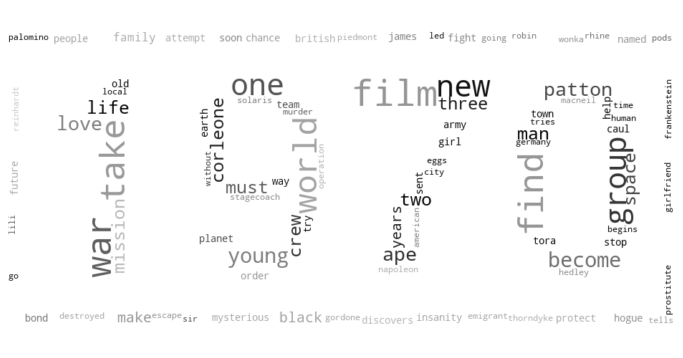

In [259]:
plot_decade_from_tfidf(1970,tfidf)

Looking at the results we find a couple of thinges that stand out. War, love, and coreleone. This make natural as important theses of the 1970's are the Anti-war movement, The gotfather movies, but can we tell if there has been a change over over the times? 

https://www.history.com/topics/1970s/1970s-1

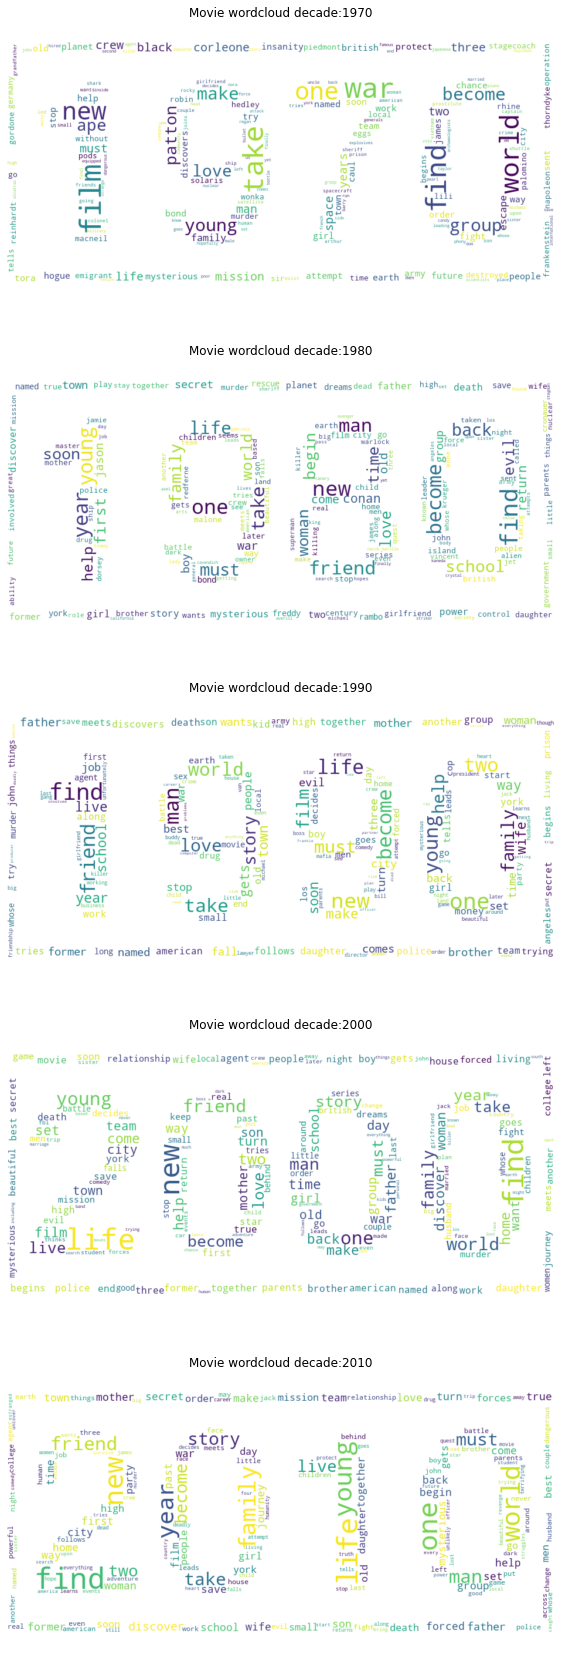

In [264]:
%matplotlib inline
nr=len(tfidf)
nc=1
fig, ax = plt.subplots(nrows=nr,ncols = nc, figsize=(25,30))
idx=0
year_keys = [x for x in tfidf.keys()]
top_words = 200

for i in range(nr):
    year = year_keys[i]
    text =' '.join([(x[0]+" ")*(int(1+x[1])) for x in sorted(tfidf[year].items(), key=lambda x: x[1], reverse=True)[0:top_words]]).replace('  ',' ')
    if str(year) not in [x.split('.')[0] for x in os.listdir()]:
        print(f"no mask found for this year{year}")
        raise Exception("Don't use this function")

    mask = np.array(Image.open(f'{year}.png'))
    image_colors = ImageColorGenerator(mask)
    #Movies
    wc = WordCloud(collocations=False,background_color="white", max_words=1000, mask=mask).generate(text)
    ax[i].imshow(wc, interpolation="bilinear")
    ax[i].set_title(f'Movie wordcloud decade:{year}')
    ax[i].axis("off")


plt.show()

In [43]:
list_for_df=[]
for y in [x for x in tfidf.keys()]:
    top_x=5
    temp_list=[]
    for idx, x in enumerate([x[0] for x in sorted(tfidf[y].items(), key=lambda x: x[1], reverse=True)[0:top_x]]):
        temp_list.append([y,x,idx+1])
    list_for_df.append(temp_list)
pd.DataFrame([y for x in list_for_df for y in x],columns=['Decade','Word','Rank']).pivot(index='Decade', columns='Rank', values='Word')

Rank       1      2      3      4      5
Decade                                  
1970     war  world    one    new  group
1980     new    one  young   find    man
1990     one    new    man   life    two
2000    life    new  young    one  world
2010    life    one    new  world  young

Looking at WordClouds and top words does not tell us a whole lot about the most central themes of the decades. It actuallly seems as if we are getting somewhat the same central themes across the line. This is a bit counter intuitive as the IDF term should correct this, but since we have a quite small samplesize in some of the decades without alot of uniqe words we seem to find the same results.

This indicates another weighing sceme might be better. 

### <span style="color:red">Check up on this</span>

But what about within a single genre? We earlier noticed that there was a development within the popularity of the comedy genre, can we also spot a change in the words?


In [182]:
# Get only comedy movies
df_comedy = df[df['genres'].apply(lambda x: True if not pd.isna(x) and ('Comedy' in [y['name'] for y in json.loads(x)]) else False)]
df_comedy=df_comedy.reset_index()
# Extracting the data from 1970 with 10 year segments
docs=load_segmented_documents(df_comedy,1970,10)
collection=[tokenize(v) for v in docs.values()]

tfidf=dict()
for year_segment, text in docs.items():
    tfidf[year_segment]=calculate_tf_idf(tokenize(text), collection)

In [183]:
list_for_df=[]
for y in [x for x in tfidf.keys()]:
    top_x=5
    temp_list=[]
    for idx, x in enumerate([x[0] for x in sorted(tfidf[y].items(), key=lambda x: x[1], reverse=True)[0:top_x]]):
        temp_list.append([y,x,idx+1])
    list_for_df.append(temp_list)
pd.DataFrame([y for x in list_for_df for y in x],columns=['Decade','Word','Rank']).pivot(index='Decade', columns='Rank', values='Word')

Rank        1     2        3     4        5
Decade                                     
1970    films   sir    hogue   one     make
1980      new  find  warlock  must     love
1990      one   new      two  life      man
2000     life   new      one   get   family
2010     life   new      one   two  friends

### <span style="color:red">COMMENTS ON DEVELOPMENT IN COMEDY GENRE</span>


### <span style="color:red">WRAP UP TF-IDF</span>


## Sentiment through the history
Now we have seen what words characterises the times through the TF-IDF analysis of the decades. Furthermore, we have gotten and idea of what happens in the world during this time compared to other decades. To dig even further in this we will now take a look at the sentiment of the words. To put it in more general terms: Can we an evolution in movie overview sentiment over times and does it change within the genres?

This will allow us later to gain a clear insight into the mood of the hollywood set and lead us to be able to answer, along with the wikipedia analysis, the question: If the world is in bad shape, do hollywood the produce more depressing/sad content?

This section we perform sentiment analysis on the movie description and relate them to the project hypotesis. To do this sentiment analysis we utilize the labMT dataset [\[3\]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) which is a "language assessment by Mechanical Turk (labMT) word list to score the happiness of a corpus. The labMT word list was created by combining the 5000 words most frequently appearing in four sources: Twitter, the New York Times, Google Books, and music lyrics, and then scoring the words for sentiment on Amazon’s Mechanical Turk" [\[4\]](https://buildmedia.readthedocs.org/media/pdf/labmt-simple/latest/labmt-simple.pdf)

#### Important decision about calculation 
Two important decision:

**Not using a lemmatizer**

The project avoids using a lemmatizer because words such as "armed" or "arm", which are stemmed to the samen word, does not have the same meaning nor the same sentiment associated to it. The same argument goes for words that are stemmed to be equal (part of lemmatization: "have" and "had" can have different sentiments.

In relation to the consideration on whether to remove stop words, the course assignment 2[REF](www.githubrepo) revealed that some stop words are non-neutral, and thus the project won't remove stop words from the texts.

A neutral word has a score of 5, and as stated in the article **Temporal Patterns of Happiness and Information in a Global Social Network[\[3\]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752)**, it makes sense to get rid of all the neutral words, because they don't say anything about the happiness of a text. Thus we remove all words with a happiness average smaller than 6 and larger than 4.
This means we choose $\Delta h_{avg} = 1$, and remove all words that lies $h_{avg}$ within the neutral score of 5, that is, $5-h_{avg}<h_{avg}<5+h_{avg}$.

Additionally preperation
* all words in the texts are set to lower case

We will start out by creating the foundation for the sentimentanalysis by loading in the data set from the supplemntary material in [\[3\]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752). And filter the data accordin to the described method above

### <span style="color:red">USE SAME DATA LOADING AS IN WIKI NOTEBOOK</span>


In [47]:
df_s = pd.read_csv('datas1.txt', sep="\t", header=None)
df_s.columns = ["word", "happiness_rank", "happiness_average", "happiness_standard_deviation", "twitter_rank", "google_rank", "nyt_rank", "lyrics_rank"]
df_s = df_s[1:]
df_s[["happiness_average", "happiness_standard_deviation"]] = df_s[["happiness_average", "happiness_standard_deviation"]].apply(pd.to_numeric)
df_s = df_s[(df_s['happiness_average']>6) | (df_s['happiness_average']<4)]

In [48]:
df_s

word happiness_rank  happiness_average  \
1       laughter              1               8.50   
2      happiness              2               8.44   
3           love              3               8.42   
4          happy              4               8.30   
5        laughed              5               8.26   
...          ...            ...                ...   
10218     murder          10218               1.48   
10219  terrorism          10219               1.48   
10220       rape          10220               1.44   
10221    suicide          10221               1.30   
10222  terrorist          10222               1.30   

       happiness_standard_deviation twitter_rank google_rank nyt_rank  \
1                            0.9313         3600          --       --   
2                            0.9723         1853        2458       --   
3                            1.1082           25         317      328   
4                            0.9949           65        1372     1313   
5                            1.1572         3334        3542       --   
...                             ...          ...         ...      ...   
10218                        1.0150         2762        3110     1541   
10219                        0.9089           --          --     3192   
10220                        0.7866         3133          --     4115   
10221                        0.8391         2124        4707     3319   
10222                        0.9091         3576          --     3026   

      lyrics_rank  
1            1728  
2            1230  
3              23  
4             375  
5            2332  
...           ...  
10218        1059  
10219          --  
10220        2977  
10221        2107  
10222          --  

[3634 rows x 8 columns]

Now that the data is loaded in, the following formula can be used to calculate the sentiment, for every decade wiki-page and the corresponding movie overview

$$V_{text} = \frac{\sum \limits_k v_k f_k}{\sum \limits_k f_k}$$

This is the sum of sentiment in the text divided by the number of words. 

As before we will take a look at a specific year again and take a look at it in depth, after wich we will aggregate the findings to more general level using all the segments (decades). The findings will then be discussed

In [49]:
def calculate_sentiment_dict(text_dict: dict):
    sentiment_dict = defaultdict(list)
    sentiment_dict_aggregate = {}
    words = list(df_s['word'])
    for year, text in text_dict.items():
        # Check if word in df_s if it is get happiness_average
        _temp = [(word.lower(),df_s[df_s['word']==word.lower()]['happiness_average'].values[0]) for word in text if not df_s[df_s['word']==word.lower()]['happiness_average'].empty]
        # Empty list
        if not _temp:
            continue
        sentiment_dict[year]=_temp
        dc = [x[0] for x in sentiment_dict[year]]
        word_count = nltk.FreqDist(dc).most_common()
        words = 0
        happy_score = 0
        for i in range(len(word_count)):
            words += word_count[i][1]
            happy_score += df_s['happiness_average'][df_s['word'] == word_count[i][0]].values[0]*word_count[i][1]
        v_text = happy_score/words
        sentiment_dict_aggregate[year]=v_text
    return sentiment_dict_aggregate, sentiment_dict

In [50]:
# Calculate sentiment for documents
decade_data = {k: tokenize(v) for k,v in docs.items()}
sentiment_decade_dict_aggregate, sentiment_decade_dict = calculate_sentiment_dict(decade_data)

We now have the calculations of sentiment from the decade segmentation of the movie industry and the wikipedia pages, but how do they relate to eachother and can we relate the sentiment to what we found in the word analysis?

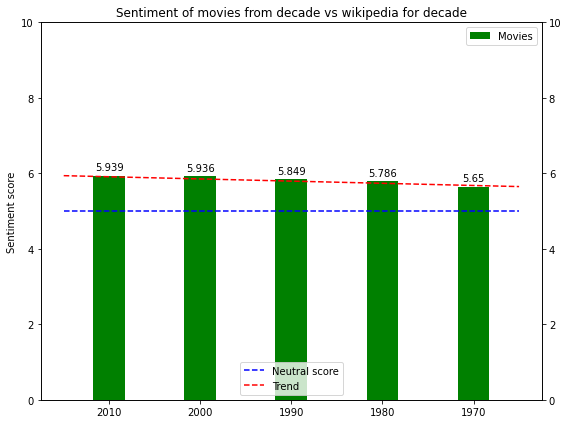

In [102]:
labels = [x[0] for x in sorted(sentiment_decade_dict_aggregate.items(),key=lambda x: x[1], reverse=True)]
movies = [round(x[1],3) for x in sorted(sentiment_decade_dict_aggregate.items(),key=lambda x: x[1], reverse=True)]
#wiki = [round(x,3) for x in list(sentiment_wiki_dict_aggregate.values())]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
#rects1 = ax.bar(x - width/2, wiki, width, label='Wikipedia')
rects2 = ax.bar(x, movies, width, label='Movies', color='g')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Sentiment score')
ax.set_title('Sentiment of movies from decade vs wikipedia for decade')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0,10])
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

#autolabel(rects1)
autolabel(rects2)
x = np.linspace(-0.5, 4.5)
y = len(x)*[5]
z = np.linspace(5.939, 5.65)
axes2 = plt.twinx()
axes2.plot(x, y, color='b', label='Neutral score',linestyle='dashed')
axes2.plot(x, z, color='r', label='Trend',linestyle='dashed')
axes2.set_ylim(0, 10)
axes2.legend(loc="lower center")
fig.tight_layout()

plt.show()

From the above plot it seems like hollywood have a slight positive sentiment, but a small downward trend in the data. The slope coefficient is very low, but maybye this is relatable to the fact that people are getting more and more depressed. In a 2018 article from the guardian listed the following statistics "From 2005-15, cases of depressive illness increased by nearly a fifth" [\[6\]](https://www.theguardian.com/news/2018/jun/04/what-is-depression-and-why-is-it-rising). But as the values are centered aroud a neutral is difficult to make any conclusions on the hypotesis. Combining this with the fact that we notice a fairly even distribution between genres we would also expect that the values would be centered around neutral as comedy might make up for horror. What should also be noted is that these text segments are evaluated in 2010/11, and therefore might not be very accurate for 1970 as words meaning and value change. Another element that might affect the sentiment score is that the short movie describtion simply dosen enough positive- or negatively charged words. This is what we will investigate next

I quick look at the sentiment word-list reveals that the most negatively charged words are about terrorism. The movie Zero Dark Thirty about the hunt for Osama Bin Larden, should then contain some negativly charged words.

In [ ]:
print("Average overview length:", np.average([len(x) for x in df['overview'].values if type(x)==str]))


In [148]:
# Adapt to function format
zdt={'Zero Dark Thirty':tokenize(df[df['original_title']=='Zero Dark Thirty']['overview'].values[0])}
zdt_agg, zdt_values =calculate_sentiment_dict(zdt)

print("Overview of Zero Dark Thirty :",df[df['original_title']=='Zero Dark Thirty']['overview'].values[0])
print(f"\nZero Dark Thirty has the sentiment: {round(zdt_agg['Zero Dark Thirty'],3)}")

Overview of Zero Dark Thirty : A chronicle of the decade-long hunt for al-Qaeda terrorist leader Osama bin Laden after the September 2001 attacks, and his death at the hands of the Navy S.E.A.L. Team 6 in May, 2011.

Zero Dark Thirty has the sentiment: 4.047


Zero dark thirty has a low sentiment as expected, but how does the distribution look for all movies in the dataset?

In [144]:
sentiment_all_movies = []
for row in df.iterrows():
    if pd.isna(row[1]['overview']):
        continue
    # Fit format
    _temp = {row[0]:tokenize(row[1]['overview'])}
    agg, val = calculate_sentiment_dict(_temp)
    if agg:
        sentiment_all_movies.append(agg)

Text(3.674999999999997, 0.5, 'Count')

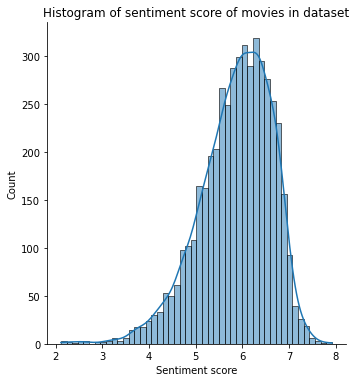

In [145]:
sns.displot([y for x in sentiment_all_movies for y in list(x.values())], kde=True)
plt.title('Histogram of sentiment score of movies across the dataset')
plt.xlabel('Sentiment score')
plt.ylabel('Count')
plt.show()

We actually have a majority of positive movies, with a few very negative ones. Here every movies is weighted equally,  but if we want to know about the expirenced sentiment of hollywood i would make more sense to do some kind of weighing on the budget of the production, as the affect a big feature film has on someone, is probably larger than a small budget movies due to advertising and other factors favoring large productions.

### <span style="color:red">SECTION WRAP UP</span>


## Analysis of Actor Communities and Their Sentiment

As presented in project assignment A, we have a hypotesis that there exist small communities within hollywood where groups of actors do the majority of their work together in specific genres. An example could be Denzel Washington which primarly does his work within Action and Drama. Does he always work with alot of the same crew?

To put it in general terms this section will uncover what actors work together, whether they form cliques? What charaterize these communites and a zoom in on specific Actors. 

This will be done through:
* Community detection
    * LIST DETECTION ALGORITHMS
* Important words
    * TF-IDF
    * Wordclouds
    * Lookup of movies
* Sentiment of communities
    * What communities are happy/sad?


## <span style="color:red">Actor communities</span>

Insert data etc.

## <span style="color:red">Actor genre distribution within communities and for communities</span>

Insert data etc.

## <span style="color:red">Section wrap up</span>


Insert data etc.

# <span style="color:red">Analysis part Three Bringing it all together - will be moved to another notebook</span>


# Comparison of results



### Comparing data tf-idf

In [332]:
# Get wiki data
wiki_data = {}
for year in tfidf.keys():
    wiki_data[year]=tokenize(process_data(look_up_decade(year)))
# All words 
collection = wiki_data.values()

# TF-IDF wiki
tfidf_wiki = {}
for year, text in wiki_data.items():
    tfidf_wiki[year]=calculate_tf_idf(text, collection)


#### Comparing to wikipedia

The above was made based on correlations between internet search and the data found based on our analysis. Now we will introduce the the earlier written wikipedia scraping method for obtaning information 



Most important words ['first', 'decade', 'world', 'united', 'also', 'states', 'war', 'popular', 'john', 'led']


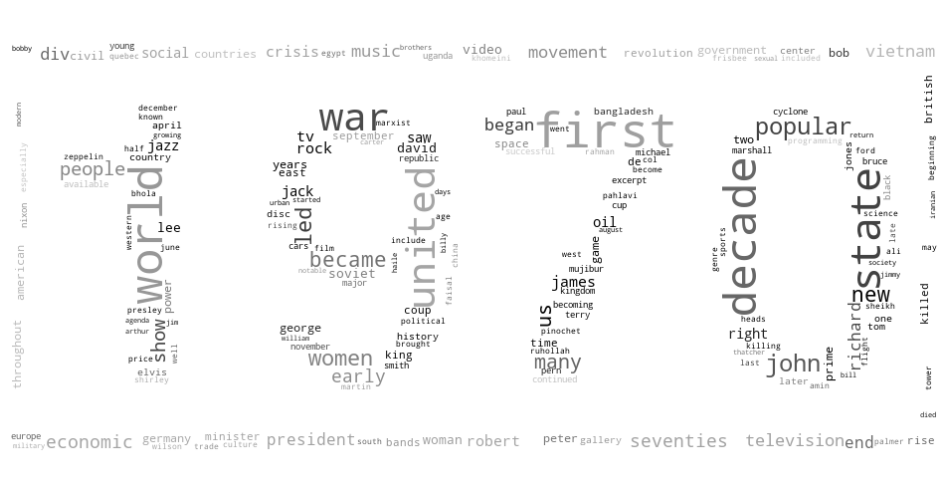

In [338]:
print("Most important words", [x[0] for x in sorted(tfidf_wiki[y].items(), key=lambda x: x[1], reverse=True)[0:10]])
plot_decade_from_tfidf(y, tfidf_wiki, top_x_words=200)

## lets look at the decades together

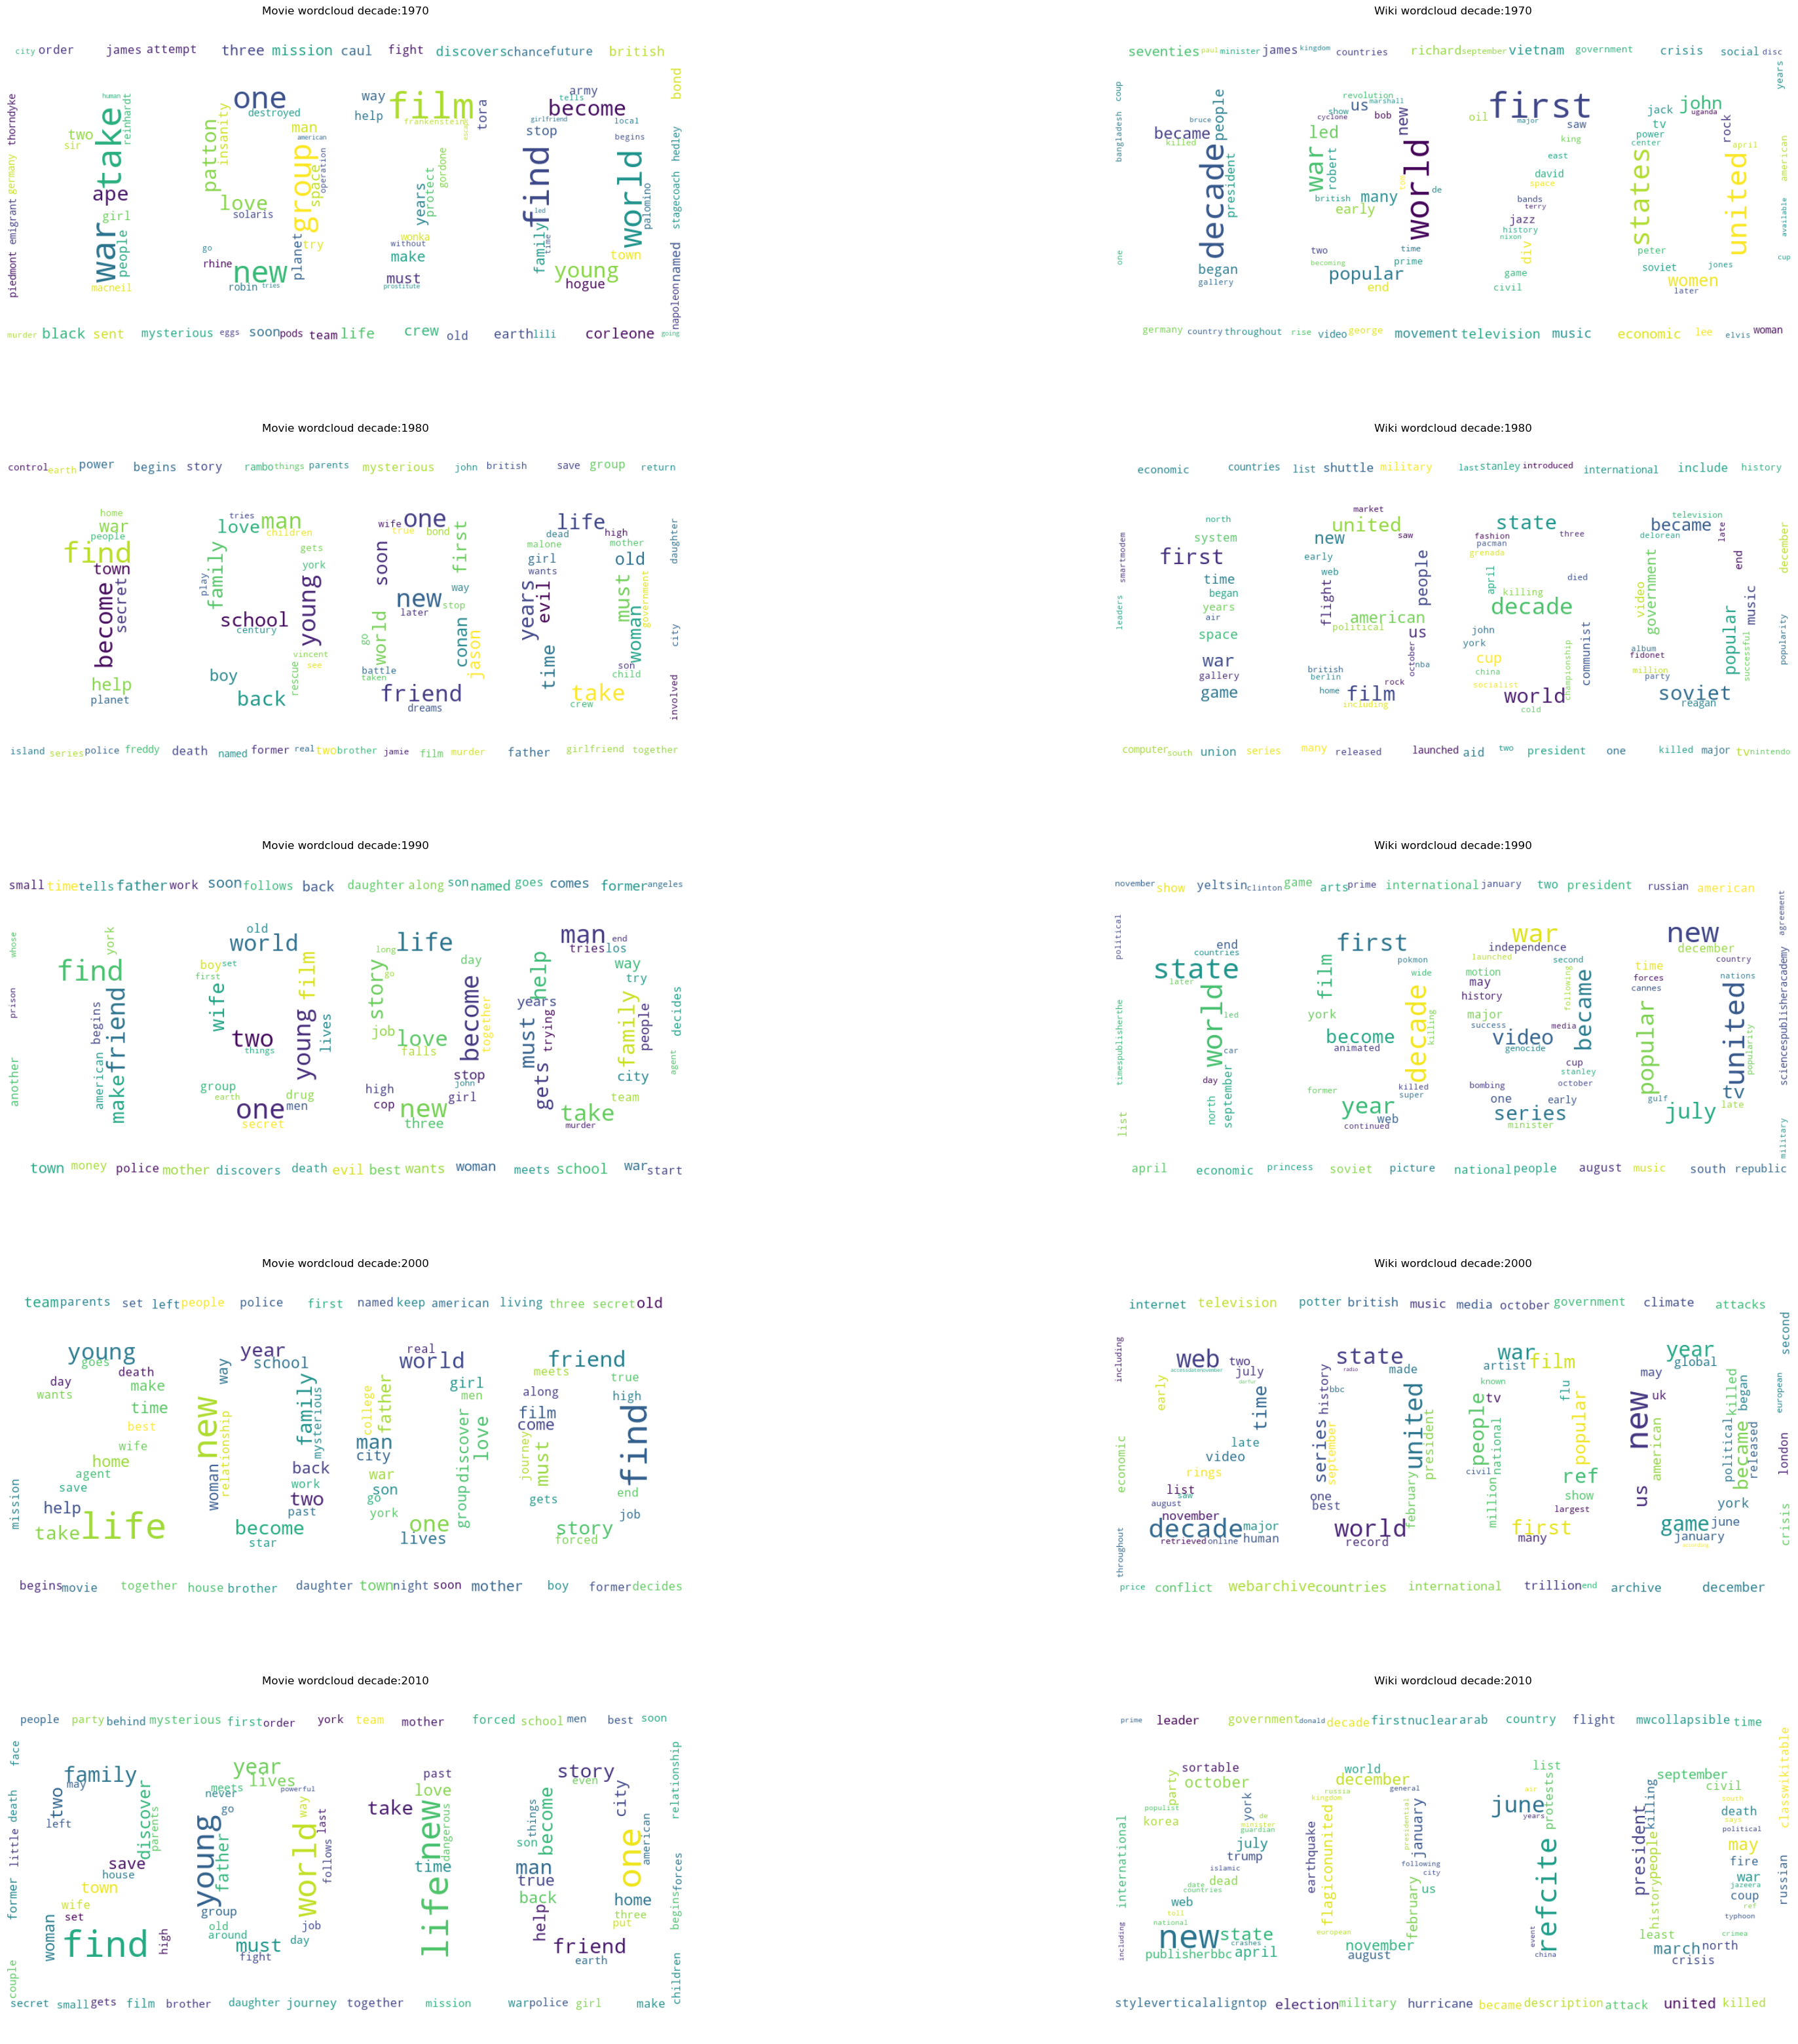

In [344]:
nr=len(tfidf)
nc=2
fig, ax = plt.subplots(nrows=nr,ncols = nc, figsize=(40,40))
idx=0
year_keys = [x for x in tfidf.keys()]
top_words = 200

for i in range(nr):
    year = year_keys[idx]
    text =' '.join([(x[0]+" ")*(int(1+x[1])) for x in sorted(tfidf[year].items(), key=lambda x: x[1], reverse=True)[0:top_x_words]]).replace('  ',' ')
    if str(year) not in [x.split('.')[0] for x in os.listdir()]:
        print(f"no mask found for this year{year}")
        raise Exception("Don't use this function")

    mask = np.array(Image.open(f'{year}.png'))
    image_colors = ImageColorGenerator(mask)
    #Movies
    wc = WordCloud(collocations=False,background_color="white", max_words=1000, mask=mask).generate(text)
    ax[i][0].imshow(wc, interpolation="bilinear")
    ax[i][0].set_title(f'Movie wordcloud decade:{year}')
    ax[i][0].axis("off")
    
    # Wiki
    text =' '.join([(x[0]+" ")*(int(1+x[1])) for x in sorted(tfidf_wiki[year].items(), key=lambda x: x[1], reverse=True)[0:top_x_words]]).replace('  ',' ')
    wc = WordCloud(collocations=False,background_color="white", max_words=1000, mask=mask).generate(text)
    ax[i][1].imshow(wc, interpolation="bilinear")
    ax[i][1].set_title(f'Wiki wordcloud decade:{year}')
    ax[i][1].axis("off")

    idx+=1
plt.show()

# Discussion of methods and data

I should be noted here that we are working with a quite  small version of the network an